<a href="https://colab.research.google.com/github/Abhi12122000/TD3_multi_agent_uav-/blob/main/td3withtau_single_UAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install box2d-py

In [12]:
!pip install gym==0.15.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import tensorflow as tf
import gym
from tensorflow.keras.models import load_model

import os
import time
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from gym import wrappers, Env, spaces
from torch.autograd import Variable
from collections import deque

In [3]:
# # Environment Class

# class Single_Agent_UAV(Env):
#     def __init__(self, initial_UAV_state = None):
#         '''
#         Initializes necessary parameters of environment (UE_positions, UAV_initial_position, EC_positions, D_array, C_array, etc.) 
#         '''
#         super(Single_Agent_UAV, self).__init__()
#         # Environment Parameters

#         self.UE_seed = 1
#         self.UE_count = 50
#         self.EC_count = 1
#         self.C_min = 100
#         self.C_max = 200
#         self.D_m_min = 1e6 # in bits
#         self.D_m_max = 5e6 # in bits
#         self.Z_max = 40
#         self.Z_min = 20
#         self.L_h_max = 49
#         self.L_v_max = 12
#         self.D_min = 100
#         self.lambda_m = 1
#         self.phi_n = np.radians(42.44)  # in degrees
#         self.g_0 = 1e-5 # in power gain # -50 in dB
#         self.B_u = 10 * 1e6  # in Hz
#         self.B_k = 0.5 * 1e6  # in Hz
#         self.P_max = 5
#         self.P_m = 0.1
#         self.P_r_n = 0.1
#         self.F_u = 3e9 # in Hz
#         self.F_e_k_max = 9e9 # in Hz
#         self.F_e_k_min = 6e9 # in Hz
#         self.kappa = (1e-28) # check if float maintains this precision
#         self.sigma_squared_u = (1e-13) # in watt # -100 in dBm
#         self.sigma_squared_e = (1e-13) # in watt # -100 in dBm
#         self.w1 = self.w2 = 1
#         self.eta_1 = 25
#         self.eta_2 = 25
#         self.eta_3 = 25
#         self.boundary_x = self.boundary_y = 150.
#         self.reward_bias = int(self.UE_count * 0.5 * self.eta_3)
#         self.max_episode_steps = 10 # Maximum number of steps in a single episode, after which environment returns done = True


#         # plotting parameters
#         self.plotting_boundary_buffer = 5.
#         self.UAV_coverage_circle_color = 'lavender'
#         self.EC_concentrated_region_color = 'mistyrose'
#         self.UAV_path_color = 'green'

#         # Environment Bounds

#         self.action_space_coversion_lb = np.zeros(4 + (self.EC_count * self.UE_count))
#         self.action_space_coversion_lb[2] = -self.L_v_max
#         self.action_space_coversion_lb[3] = 1e-2
#         self.action_space_coversion_ub = np.ones(4 + (self.EC_count * self.UE_count))
#         self.action_space_coversion_ub[0:4] = np.array([self.L_h_max, 2 * math.pi, self.L_v_max, self.P_max]) 

#         self.action_space_lb = -1 * np.ones(4 + (self.EC_count * self.UE_count))
#         self.action_space_ub = np.ones(4 + (self.EC_count * self.UE_count))
#         self.state_space_lb = np.array([0, 0, self.Z_min])
#         self.state_space_ub = np.array([self.boundary_x, self.boundary_y, self.Z_max])


# #         self.state_shape = 
# #         defining action space
#         self.state_space = gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub)
# #         defining observation space
#         self.action_space = gym.spaces.box.Box(low = self.action_space_lb, high = self.action_space_ub)
        
#         self.timesteps_in_episode = 0
#         self.done = False
#         self.last_action = self.action_space.sample()

#         self.UE_positions = []
#         self.EC_positions = []
#         self.EC_F_e_k = []
#         self.D_array = []
#         self.C_array = []
# #         initialize grid dimensions (400 x 400) 
#         if initial_UAV_state is not None:
#           self.current_state = np.array(initial_UAV_state)
#         else:
#           self.current_state = self.select_random_state()
        
#         self.initial_UAV_state = self.current_state
        
#         self.previous_state = self.current_state
#         print("initial state of UAV: ", self.current_state)
    
# #         call function to place UEs on the grid and specify (D_m, C_m, lambda_m) for UAVs
#         self.place_UEs(position="centered", desired_z_coord = (self.Z_min + self.Z_max) / 2, center = None)
#         self.place_ECs_randomly()


#     def get_count_of_UEs_covered(self):
#         '''
#         Returns count of UEs covered under UAV's current configuration
#         '''

#         C_max_t = (self.current_state[2] / np.tan(self.phi_n))
        
#         ground_UAV_state = np.zeros(3)
#         ground_UAV_state[:2] = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         # print("distance b/w UEs and UAV: ", dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()

#         return M_t


#     def render_UAV_movement_through_episode(self, **kwargs):
#         '''
#         Helper function to visualize UAV movement through an episode
#         Arguments: A list specifying UAV positions throughout the episode
#         '''

#         if 'reward' not in kwargs:
#             kwargs['reward'] = 'Not known'
        
#         C_max_t = (kwargs['UAV_positions_list'][-1][2] / np.tan(self.phi_n))
#         buffer = 5.
#         fig, ax = plt.subplots(1, figsize=(10,10))
#         ax.set_xlim(-buffer, self.boundary_x+buffer)
#         ax.set_ylim(-buffer, self.boundary_y+buffer)
#         ax.grid()
#         UE_x = self.UE_positions[:, 0]
#         UE_y = self.UE_positions[:, 1]
#         ax.plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
#         EC_x = self.EC_positions[:, 0]
#         EC_y = self.EC_positions[:, 1]
#         ax.plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
#         ax.plot(np.array(kwargs['UAV_positions_list'])[:, 0] , np.array(kwargs['UAV_positions_list'])[:, 1], color=self.UAV_path_color, markersize=6, linestyle = '-', label = "UAV Path Color")
#         ax.plot(kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV ending position")
        
#         UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1]), C_max_t, color = self.UAV_coverage_circle_color)
#         ax.add_artist(UAV_coverage_area)
      
#       # For testing: To plot the circle and visualize UE points inside it
#         if self.UE_center is not None:
#             Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
#             ax.add_artist(Test_UE_allotment_circle)
#       # End

#         ax.set_aspect(1)
#         # naming the x axis
#         ax.set_xlabel('X pos (m)')
#         # naming the y axis
#         ax.set_ylabel('Y pos (m)')
#         ax.set_title('UAV movement through episode')
#         # giving a title to my graph
#         # plt.title('Visually Appealing!')

#         # show a legend on the plot
#         ax.legend()
#         # plt.show()
#         return


#     def render_bar_plot(self, ax, plot_number, idx):
#         '''
#         Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
#         '''
#         x_indices = np.arange(self.UE_count)
#         width = 0.5

#         gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
#         gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
#         ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
#         for i in range(self.EC_count):
#             ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
#     def render_position_plot(self, ax, plot_number, idx, reward):
#         '''
#         Helper function to render(), plots the current position plot on given axes. 
#         Plotting position plot of UAV's current position and coverage
#         '''

#         C_max_t = (self.current_state[2] / np.tan(self.phi_n))
#         buffer = 5.
#         ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
#         ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
#         ax[plot_number, idx].grid()
#         UE_x = self.UE_positions[:, 0]
#         UE_y = self.UE_positions[:, 1]
#         ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
#         EC_x = self.EC_positions[:, 0]
#         EC_y = self.EC_positions[:, 1]
#         ax[plot_number, idx].plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
#         ax[plot_number, idx].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
#         UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), C_max_t, color = self.UAV_coverage_circle_color)
#         ax[plot_number, idx].add_artist(UAV_coverage_area)
      
#       # For testing: To plot the circle and visualize UE points inside it
#         if self.UE_center is not None:
#             Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
#             ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
#       # End

#         ax[plot_number, idx].set_aspect(1)
#         # naming the x axis
#         ax[plot_number, idx].set_xlabel('X pos (m)')
#         # naming the y axis
#         ax[plot_number, idx].set_ylabel('Y pos (m)')
#         ax[plot_number, idx].set_title('reward: ' + str(reward))
#         # giving a title to my graph
#         # plt.title('Visually Appealing!')

#         # show a legend on the plot
#         ax[plot_number, idx].legend()
#         # plt.show()


#     def render(self, **kwargs):
#         '''
#         Function to visualize UAV position
#         (this function has different configurations for different use cases)
#         '''

#         if 'UAV_positions_list' in kwargs:
#             self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

#         if 'fig' not in kwargs:
#             fig, ax = plt.subplots(1, 2, figsize=(20,10))
#             ax = np.array([ax])
#             kwargs['fig'] = fig
#             kwargs['ax'] = ax
#             kwargs['i'] = 0
        
#         if 'reward' not in kwargs:
#             kwargs['reward'] = 'Not known'
#         self.render_position_plot(kwargs['ax'], kwargs['i'], 0, kwargs['reward'])
#         if(self.timesteps_in_episode != 0):
#             self.render_bar_plot(kwargs['ax'], kwargs['i'], 1)


#     def reset(self):
#         '''
#         Resets the environment paramters to some initial values
#         '''
# #         we should only reassign the position of UAV here
#         # Commenting for TESTING
#         self.current_state = self.select_random_state()
#         # Commenting for TESTING done
#         self.this_episode_UAV_positions_list = []
#         # self.current_state = self.initial_UAV_state
#         print("new initial state of UAV (after resetting): ", self.current_state)

#         self.timesteps_in_episode = 0
#         self.done = False
#         return self.current_state
    
    
#     def step(self, action):
#         '''
#         Takes action moving environment from current_state to next_state
#         Arguments: `action` to be taken
#         Returns: new_state, reward, done, info(=None)
#         '''
#         # print("printing action in step function: ", action)
#         action = np.array(action).flatten()
#         action = np.clip(action, self.action_space_lb, self.action_space_ub)
#         # print("clipped action inside Environment: ", action)
#         action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
#         # print("scaled action: ", action)
# #         action is of the form [l_n(t), v_n(t), del_z_n(t), P_t_n(t), gamma_0_1(t), ..., gamma_0_k(t), gamma_1_1(t), ..., gamma_1_k(t), ..., gamma_m_k(t)]
# #         What happens if (sum of gamma_n_m_k != 1) ?
# #         The above problem has been dealt by not including gamma_i_0(t) in predicted action.
# #         Rather, we evaluate it as:- gamma_i_0(t) = 1 - summation(gamma_i_k(t))
#         # print("action just before moving: ", action.shape[0])
#         self.timesteps_in_episode += 1
#         # print("P_t of action: ", action[3])
#         action = self.move(action)
#         print("UAV position: ", self.current_state)
#         self.last_action = action
#         # print("action after moving: ", action)
        
#         gamma_array = (np.array(action[4:])).reshape((self.UE_count, self.EC_count))
#         gamma_zeros = (1 - gamma_array.sum(axis = 1))
#         # print("gamma zeros: ", gamma_zeros)
        
# # REMOVED CODE
# #         gamma_array = []
# #         gamma_zeros = []
# #         for i in range(len(self.UE_positions)):
# #             base = 4
# #             sum_gamma_i = 0
# #             gamma_i_array = []
# #             for j in range(EC_count):
# #                 gamma_i_array.append(action[base + (i * EC_count) + j])
# #                 sum_gamma_i += gamma_i_array[-1]
# #             gamma_array.append(np.array(gamma_i_array))
# #             gamma_zeros.append(1 - sum_gamma_i)
    
# #         gamma_zeros = np.array(gamma_zeros)
# #         gamma_array = np.array(gamma_array)
# # END OF REMOVED CODE
        
# #         calculate C_max_t for UAV (using correct formula)
#         C_max_t = (self.current_state[2] / np.tan(self.phi_n))
        
#         ground_UAV_state = np.zeros(3)
#         ground_UAV_state[:2] = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         # print("distance b/w UEs and UAV: ", dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()  # no. of UEs served by the agent
#         # print("UEs covered: ", M_t)
#         # print("M_t: ", M_t, " C_max_t: ", C_max_t)
        
#         try:
#             if(M_t==0):
#                 raise ValueError("-----UAV serves no UEs in its present state-----")
        
#         except ValueError:
#             #Reward: 
#             reward = coverage_penalty = -1 * (self.UE_count - M_t) * self.eta_3  # coverage constraint penalty
#             reward += self.reward_bias
#             # print("coverage penalty = reward:- ", coverage_penalty)
#             self.is_done()
    
#             # if(self.done):
#             #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
    

#             return self.current_state, reward, self.done, None
            
        
#         dist_EC_UAV = np.linalg.norm(self.EC_positions - self.current_state, axis = 1)
#         # print("distance b/w ECs and UAV: ", dist_EC_UAV)

# # REMOVED CODE
# #         for current_UE in self.UE_positions:
# #             dist_i = np.linalg.norm(current_UE - self.current_state)
# #             dist_UE_UAV.append(dist_i)
# #             if(np.square(C_max_t) >= dist_i):
# #                 M_t += 1
        
# #         for current_EC in self.EC_positions:
# #             dist_i = np.linalg.norm(current_EC - self.current_state) 
# #             dist_EC_UAV.append(dist_i)
        
# #         dist_UE_UAV = np.array(dist_UE_UAV)
# #         dist_EC_UAV = np.array(dist_EC_UAV)
# # END OF REMOVED CODE

        
# # Calculating Reward here
        
# #     A.) G2A Transmission from UEs to UAVs

#         # print("-------displaying stats for UAV-1:------- ")
#         h_m = self.g_0 / np.square(dist_UE_UAV)
#         # print("h_m: ", h_m[0])
#         R_m = (self.B_u * np.log2(1 + ((h_m * self.P_m) / self.sigma_squared_u))) / M_t   # shannon channel capacity equation
#         # print("R_m: ", R_m[0])
#         # print("D_array: ", self.D_array[0], self.D_array.shape)
#         # print("R_m: ", R_m[0], R_m.shape)
#         T_G2A_t_list = (self.D_array / R_m)
#         # print("printing array division: ", (self.D_array / R_m))
#         # print("T_G2A_t: ", T_G2A_t_list[0])
#         E_G2A_t_list = (self.P_r_n * T_G2A_t_list)
        
    
# #     B.) Computation at UAVs
        
#         f_i = self.F_u / M_t
#         # print("f_i: ", f_i)
#         E_UAV_helper_constant = self.kappa * (f_i ** 3)
#         T_UAV_t_list = ((gamma_zeros * self.D_array * self.C_array) / f_i)
#         E_UAV_t_list = (E_UAV_helper_constant * T_UAV_t_list)
            
    
# #     C.) A2G Transmission from UAVs to ECs
        
#         h_k = self.g_0 / (np.square(dist_EC_UAV))
#         R_k = (self.B_k * np.log2(1 + ((h_k * action[3]) / self.sigma_squared_e)))
#         # print("power P_t: ", action[3])
#         # print("R_k for A2G Transmission: ", R_k)
#         T_A2G_t_list = (gamma_array * (self.D_array)[:, np.newaxis]) / R_k  #each element of the list is an numpy array describing each UE
#         E_A2G_t_list = (T_A2G_t_list * action[3])
    
    
# #     D.) Computation at the ECs
#         T_EC_t_list = ((gamma_array * (self.D_array)[:, np.newaxis]) * (self.C_array)[:, np.newaxis]) / (self.EC_F_e_k / self.UE_count)
    
    

#         # print("rho_array: ", rho_array)
#         # print("T_G2A_t_list", T_G2A_t_list)
#         # print("E_G2A_t_list", E_G2A_t_list)
#         # print("T_UAV_t_list", T_UAV_t_list)
#         # print("E_UAV_t_list", E_UAV_t_list)
#         # print("T_A2G_t_list", T_A2G_t_list)
#         # print("E_A2G_t_list", E_A2G_t_list)
        
#         E_t = (rho_array * self.lambda_m * (E_G2A_t_list + E_UAV_t_list + (E_A2G_t_list.sum(axis = 1)))).sum()
#         T_t = (rho_array * (T_G2A_t_list + np.maximum(T_UAV_t_list, (T_A2G_t_list + T_EC_t_list).max(axis = 1)))).sum()
        
#         U_t = (self.w1 * E_t) + (self.w2 * T_t)  # objective function
#         # print("U_t: ", U_t)
        
#     #Reward: 
#         coverage_penalty = -1 * (self.UE_count - M_t) * self.eta_3  # coverage constraint penalty
#         # print("coverage penalty: ", coverage_penalty)
    
#         #TODO for multi-agent:
#         overlapping_penalty = 0  # overlapping constraint penalty
#         collision_penalty = 0  # collision constraint penalty
        
        
#         if(M_t != self.UE_count):
#             reward = coverage_penalty + overlapping_penalty + collision_penalty  # complete this
#         else:
#             reward = -1 * U_t
            
#         reward += self.reward_bias
#         # print("reward: ", reward)
            
#         self.is_done()

#         # if(self.done):
#         #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
        
#         return self.current_state, reward, self.done, None
    
    
#     def is_done(self):
#         '''
#         Helper function to check if episode needs to be terminated
#         '''
#         if(self.timesteps_in_episode >= self.max_episode_steps):
#             self.done = True
    
    
#     def select_random_state(self):
#         '''
#         Selects and assigns random initial state (within bounds) to the UAV
#         '''
#         new_x = np.random.uniform(0.0, self.boundary_x)
#         new_y = np.random.uniform(0.0, self.boundary_y)
#         new_z = np.random.uniform(self.Z_min, self.Z_max)
# #         new_x = math.floor(np.random.uniform(0.0, boundary_x) * 100) / 100
# #         new_y = math.floor(np.random.uniform(0.0, boundary_y) * 100) / 100
# #         new_z = math.floor(np.random.uniform(Z_min, Z_max) * 100) / 100
        
#         return np.array([new_x, new_y, new_z])
    
    
#     def move(self, action):
#         '''
#         Helper function to step() function.
#         Clips the passed action to fit within action space bounds.
#         Calculates new state after performing the passed action, and updates UAV position accordingly. 
#         '''
# #         evaluates new state reached upon performing the move and saves it in self.current_state
# #         returns the clamped action

#         # print("action length after move 1: ", action.shape[0])
#         self.previous_state = self.current_state
#         # print("current state before moving: ", self.previous_state)
#     # updating vertical flight new state:
#         delta_z = action[2] = np.clip(action[2], -self.L_v_max, self.L_v_max)
#         z_next = np.clip(self.current_state[2] + delta_z, self.Z_min, self.Z_max)
#         # print("action length after move 2: ", action.shape[0])
#     # updating gamma parameters in action:
#         action[3] = np.clip(action[3], 0, self.P_max)
#         # print("action length after move 3: ", action.shape[0])
#         gamma_remaining = np.ones(self.UE_count, dtype = np.float32)
#         gamma_array = np.clip((np.array(action[4:])).reshape((self.UE_count, self.EC_count)), 0.0, 1.0)
#         for m in range(self.UE_count):
#             for k in range(self.EC_count):
#                 gamma_array[m][k] = np.clip(gamma_array[m][k], 0.0, gamma_remaining[m])
#                 gamma_remaining[m] -= gamma_array[m][k]    
#         action[4:] = gamma_array.flatten()
    
#         # print("action length after move 4: ", action.shape[0])
    
#     # updating horizontal_fly_distance and horizontal_direction_angle
#         action[0] = horizontal_fly_distance = np.clip(action[0], 0, self.L_h_max)
#         action[1] = horizontal_direction_angle = np.clip(action[1], 0, 2 * math.pi)
#         # print("action length after move 5: ", action.shape[0])    
#         # print("horizontal direction angle: ", horizontal_direction_angle)
#         x_next_dash = self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)) 
#         y_next_dash = self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle))
    
#     # updating horizontal_direction_angle if the new move is out of boundary
#         if((x_next_dash < 0) or (x_next_dash > self.boundary_x) or (y_next_dash < 0) or (y_next_dash > self.boundary_y)):
#             action[1] = horizontal_direction_angle = np.random.uniform(0, 2 * math.pi)
        
#     # updating new planar co-ordinates (x_next, y_next)
#         x_next = np.clip(self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)), 0., self.boundary_x)
#         y_next = np.clip(self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle)), 0., self.boundary_y)
        
#         self.current_state = np.array([x_next, y_next, z_next])
        
#         # print("new state after move: ", self.current_state)
        
#         # print("action: ", action)
#         return action
        

#     def helper_assign_Dm_Cm_to_UEs(self):
#         '''
#         Initializes D_array and C_array (denoting D_m and C_m values for each UE)
#         '''
#         for _ in range(self.UE_count):
#             D_m = np.random.randint(self.D_m_min, self.D_m_max)
#             self.D_array.append(D_m)
#             C_m = np.random.randint(100, 200)
#             self.C_array.append(C_m)
#         self.D_array = np.array(self.D_array)
#         self.C_array = np.array(self.C_array)
#         # W = [D_m, C_m, lambda_m]
#         return

    
#     def place_UEs_centered(self, desired_z_coord = None, center = None, centered_UE_count = None):
#         '''
#         Helper function to place_UEs
#         Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
#         Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
#         Arguments: 
#             desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
#             center: Provides center of circular region in which UEs will be scattered
#             centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
#         '''

#         if centered_UE_count is None:
#           centered_UE_count = self.UE_count
#         # focuses the UEs inside the circular region
#         if(desired_z_coord == None): 
#           height_ = self.Z_max
#         else:
#           height_ = desired_z_coord
#         radius = C_max_t = (height_ / np.tan(self.phi_n))
#         if(center == None):
#             # (x, y) co-ordinates
#             x = np.random.uniform(0, self.boundary_x)
# #             x = math.ceil(x*100)/100
#             y = np.random.uniform(0, self.boundary_y)
# #             y = math.ceil(y*100)/100
#             center = np.array([x, y, 0.])

#         r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
#         theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

#       # For testing: To plot the circle and visualize UE points inside it
#         self.UE_center = center
#         self.UE_radius = radius
#         # print("self.UE_center: ", self.UE_center, " self.UE_radius: ", self.UE_radius)
#       # End

#         self.UE_positions = np.zeros((centered_UE_count, 3))
#         self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
#         self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
#         return


#     def place_UEs_randomly(self, random_UE_count = None, **kwargs):
#         '''
#         Helper function to place_UEs
#         places `random_UE_count` UEs randomly onto the rectangular region
#         if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
#         and `exclude_radius` is excluded

#         '''

#         if random_UE_count is None:
#           random_UE_count = self.UE_count

#         # places UE_count UEs on grid randomly
#         if type(self.UE_positions) == np.ndarray:
#             self.UE_positions = self.UE_positions.tolist()

#         randomly_placed_count = 0
#         while(randomly_placed_count < random_UE_count):
#             #(x, y) co-ordinates
#             x = np.random.uniform(0, self.boundary_x)
# #             x = math.ceil(x*100)/100
#             y = np.random.uniform(0, self.boundary_y)
# #             y = math.ceil(y*100)/100
#             coords = np.array((x, y, 0.))
#             if 'exclude_center' in kwargs:
#                 if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
#                     continue
#             self.UE_positions.append(coords)
#             randomly_placed_count += 1

#         self.UE_positions = np.array(self.UE_positions)


#     def place_UEs(self, position="random", desired_z_coord = None, center = None):
#         '''
#         Function to place UEs onto the rectangular region
#         Arguments:
#             position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
#             desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
#             center: if position="centered", this argument provides center of circular region
#         '''

#         self.UE_center = None  # initializing for non-centered generation algorithms

#         if(position=="centered"):
#             ratio = 0.65
#             centered_count = int(ratio * self.UE_count)
#             self.place_UEs_centered(desired_z_coord, center, centered_count)
#             if(self.UE_count - centered_count > 0):
#                 self.place_UEs_randomly(self.UE_count - centered_count, exclude_center = self.UE_center, exclude_radius = self.UE_radius)
#         elif(position=="random"):
#             self.place_UEs_randomly()

#         # saves in self.UE_coord_list, assigns (D_m, C_m, lambda_m) to them
#         self.UE_positions = np.array(self.UE_positions)
#         self.helper_assign_Dm_Cm_to_UEs()
#         # print("UE positions: ", self.UE_positions)
#         # print("D_m array: ", self.D_array)
#         # print("C_m array: ", self.C_array)
#         return


#     def place_ECs_randomly(self):
#         '''
#         Function to scatter EC_count ECs throughout rectangular region
#         '''

# #         places EC_count ECs in random locations
# #         randomly assigns F_e_k for all ECs
#         for _ in range(self.EC_count):
#             x = np.random.uniform(0, self.boundary_x)
# #             x = math.ceil(x*100)/100
#             y = np.random.uniform(0, self.boundary_y)
# #             y = math.ceil(y*100)/100
#             coords = np.array((x, y, 0.))
#             # coords[:2] = self.UE_center

#             #TESTING CODE
#             self.EC_positions.append(coords)
#             #END

#             self.EC_F_e_k.append(np.random.randint(self.F_e_k_min, self.F_e_k_max, dtype = np.int64))
#         self.EC_F_e_k = np.array(self.EC_F_e_k)
#         self.EC_positions = np.array(self.EC_positions)
        
#         # print("EC positions: ", self.EC_positions)
#         # print("Computation resource at ECs F^e_k: ", self.EC_F_e_k)
        
#         return

In [4]:
# # Environment Class

# class Single_Agent_UAV(Env):
#     def __init__(self, initial_UAV_state = None):
#         '''
#         Initializes necessary parameters of environment (UE_positions, UAV_initial_position, EC_positions, D_array, C_array, etc.) 
#         '''
#         super(Single_Agent_UAV, self).__init__()
#         # Environment Parameters

#         self.UE_seed = 1
#         self.UE_count = 60
#         self.EC_count = 1
#         self.C_min = 100
#         self.C_max = 200
#         self.D_m_min = 1e6 # in bits
#         self.D_m_max = 5e6 # in bits
#         self.Z_max = 40
#         self.Z_min = 20
#         self.L_h_max = 49
#         self.L_v_max = 12
#         self.D_min = 100
#         self.lambda_m = 1
#         self.phi_n = np.radians(42.44)  # in degrees
#         self.g_0 = 1e-5 # in power gain # -50 in dB
#         self.B_u = 10 * 1e6  # in Hz
#         self.B_k = 0.5 * 1e6  # in Hz
#         self.P_max = 5
#         self.P_m = 0.1
#         self.P_r_n = 0.1
#         self.F_u = 3e9 # in Hz
#         self.F_e_k_max = 9e9 # in Hz
#         self.F_e_k_min = 6e9 # in Hz
#         self.kappa = (1e-28) # check if float maintains this precision
#         self.sigma_squared_u = (1e-13) # in watt # -100 in dBm
#         self.sigma_squared_e = (1e-13) # in watt # -100 in dBm
#         self.w1 = self.w2 = 1
#         self.eta_1 = 25
#         self.eta_2 = 25
#         self.eta_3 = 25
#         self.boundary_x = self.boundary_y = 150.
#         self.reward_bias = int(self.UE_count * 0.5 * self.eta_3)
#         self.max_episode_steps = 10 # Maximum number of steps in a single episode, after which environment returns done = True


#         # plotting parameters
#         self.plotting_boundary_buffer = 5.
#         self.UAV_coverage_circle_color = 'lavender'
#         self.EC_concentrated_region_color = 'mistyrose'
#         self.UAV_path_color = 'green'

#         # Environment Bounds

#         self.action_space_coversion_lb = np.zeros(3)
#         self.action_space_coversion_lb[2] = -self.L_v_max
#         self.action_space_coversion_ub = np.ones(3)
#         self.action_space_coversion_ub[0:3] = np.array([self.L_h_max, 2 * math.pi, self.L_v_max]) 

#         self.action_space_lb = -1 * np.ones(3)
#         self.action_space_ub = np.ones(3)
#         self.state_space_lb = np.array([0, 0, self.Z_min])
#         self.state_space_ub = np.array([self.boundary_x, self.boundary_y, self.Z_max])


# #         self.state_shape = 
# #         defining action space
#         self.state_space = gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub)
# #         defining observation space
#         self.action_space = gym.spaces.box.Box(low = self.action_space_lb, high = self.action_space_ub)
        
#         self.timesteps_in_episode = 0
#         self.done = False
#         self.last_action = self.action_space.sample()

#         self.UE_positions = []
#         self.EC_positions = []
#         self.EC_F_e_k = []
#         self.D_array = []
#         self.C_array = []
# #         initialize grid dimensions (400 x 400) 
#         if initial_UAV_state is not None:
#           self.current_state = np.array(initial_UAV_state)
#         else:
#           self.current_state = self.select_random_state()
        
#         self.initial_UAV_state = self.current_state
        
#         self.previous_state = self.current_state
#         print("initial state of UAV: ", self.current_state)
    
# #         call function to place UEs on the grid and specify (D_m, C_m, lambda_m) for UAVs
#         self.place_UEs(position="centered", desired_z_coord = (self.Z_min + self.Z_max) / 2, center = None)
#         self.place_ECs_randomly()


#     def get_count_of_UEs_covered(self):
#         '''
#         Returns count of UEs covered under UAV's current configuration
#         '''

#         C_max_t = (self.current_state[2] / np.tan(self.phi_n))
        
#         ground_UAV_state = np.zeros(3)
#         ground_UAV_state[:2] = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         # print("distance b/w UEs and UAV: ", dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()

#         return M_t

    
#     def render_policy_plot(self, **kwargs):

#         fig, ax = plt.subplots(1, figsize=(10,10))
#         position_action_list = kwargs['position_action_list']
#         for position_action in position_action_list:
#             position = position_action[0]
#             action = position_action[1]
#             new_state = self.move(action, get_new_state=True)
#             ax.arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.09, head_length=0.1)
#         plt.show()
#         return


#     def render_UAV_movement_through_episode(self, **kwargs):
#         '''
#         Helper function to visualize UAV movement through an episode
#         Arguments: A list specifying UAV positions throughout the episode
#         '''

#         if 'reward' not in kwargs:
#             kwargs['reward'] = 'Not known'
        
#         C_max_t = (kwargs['UAV_positions_list'][-1][2] / np.tan(self.phi_n))
#         buffer = 5.
#         fig, ax = plt.subplots(1, figsize=(10,10))
#         ax.set_xlim(-buffer, self.boundary_x+buffer)
#         ax.set_ylim(-buffer, self.boundary_y+buffer)
#         ax.grid()
#         UE_x = self.UE_positions[:, 0]
#         UE_y = self.UE_positions[:, 1]
#         ax.plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
#         EC_x = self.EC_positions[:, 0]
#         EC_y = self.EC_positions[:, 1]
#         ax.plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
#         ax.plot(np.array(kwargs['UAV_positions_list'])[:, 0] , np.array(kwargs['UAV_positions_list'])[:, 1], color=self.UAV_path_color, markersize=6, linestyle = '-', label = "UAV Path Color")
#         ax.plot(kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV ending position")
        
#         UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1]), C_max_t, color = self.UAV_coverage_circle_color)
#         ax.add_artist(UAV_coverage_area)
      
#       # For testing: To plot the circle and visualize UE points inside it
#         if self.UE_center is not None:
#             Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
#             ax.add_artist(Test_UE_allotment_circle)
#       # End

#         ax.set_aspect(1)
#         # naming the x axis
#         ax.set_xlabel('X pos (m)')
#         # naming the y axis
#         ax.set_ylabel('Y pos (m)')
#         ax.set_title('UAV movement through episode')
#         # giving a title to my graph
#         # plt.title('Visually Appealing!')

#         # show a legend on the plot
#         ax.legend()
#         # plt.show()
#         return


#     def render_bar_plot(self, ax, plot_number, idx):
#         '''
#         Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
#         '''
#         x_indices = np.arange(self.UE_count)
#         width = 0.5

#         gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
#         gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
#         ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
#         for i in range(self.EC_count):
#             ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
#     def render_position_plot(self, **kwargs):
#         '''
#         Helper function to render(), plots the current position plot on given axes. 
#         Plotting position plot of UAV's current position and coverage
#         '''
#         ax = kwargs['ax']
#         plot_number = kwargs['i']
#         idx = 0
#         reward = kwargs['reward']

#         C_max_t = (self.current_state[2] / np.tan(self.phi_n))
#         buffer = 5.
#         ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
#         ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
#         ax[plot_number, idx].grid()
#         UE_x = self.UE_positions[:, 0]
#         UE_y = self.UE_positions[:, 1]
#         ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
#         EC_x = self.EC_positions[:, 0]
#         EC_y = self.EC_positions[:, 1]
#         ax[plot_number, idx].plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
#         ax[plot_number, idx].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
#         UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), C_max_t, color = self.UAV_coverage_circle_color)
#         ax[plot_number, idx].add_artist(UAV_coverage_area)
      
#       # For testing: To plot the circle and visualize UE points inside it
#         if self.UE_center is not None:
#             Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
#             ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
#       # End

#         if 'learnt_policy_visualization' in kwargs:
#             position_action_list = kwargs['position_action_list']
#             for position_action in position_action_list:
#                 position = position_action[0]
#                 action = position_action[1]
#                 action = np.clip(action, self.action_space_lb, self.action_space_ub)
#                 action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
#                 # print("action after scaling: ", action)
#                 new_state = self.move(action, get_new_state=True, provided_center=position)
#                 # print("new_state: ", new_state)
#                 ax[plot_number, idx].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
#                 ax[plot_number, idx].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
#                 ax[plot_number, idx].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


#         ax[plot_number, idx].set_aspect(1)
#         # naming the x axis
#         ax[plot_number, idx].set_xlabel('X pos (m)')
#         # naming the y axis
#         ax[plot_number, idx].set_ylabel('Y pos (m)')
#         ax[plot_number, idx].set_title('reward: ' + str(reward))
#         # giving a title to my graph
#         # plt.title('Visually Appealing!')

#         # show a legend on the plot
#         ax[plot_number, idx].legend()
#         # plt.show()


#     def render(self, **kwargs):
#         '''
#         Function to visualize UAV position
#         (this function has different configurations for different use cases)
#         '''

#         if 'UAV_positions_list' in kwargs:
#             self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

#         if 'fig' not in kwargs:
#             fig, ax = plt.subplots(1, 2, figsize=(20,10))
#             ax = np.array([ax])
#             kwargs['fig'] = fig
#             kwargs['ax'] = ax
#             kwargs['i'] = 0
        
#         if 'reward' not in kwargs:
#             kwargs['reward'] = 'Not known'
#         self.render_position_plot(**kwargs)
#         # if(self.timesteps_in_episode != 0):
#         #     self.render_bar_plot(kwargs['ax'], kwargs['i'], 1)


#     def reset(self):
#         '''
#         Resets the environment paramters to some initial values
#         '''
# #         we should only reassign the position of UAV here
#         # Commenting for TESTING
#         self.current_state = self.select_random_state()
#         # Commenting for TESTING done
#         self.this_episode_UAV_positions_list = []
#         # self.current_state = self.initial_UAV_state
#         # print("new initial state of UAV (after resetting): ", self.current_state)

#         self.timesteps_in_episode = 0
#         self.done = False
#         return self.current_state
    
    
#     def step(self, action):
#         '''
#         Takes action moving environment from current_state to next_state
#         Arguments: `action` to be taken
#         Returns: new_state, reward, done, info(=None)
#         '''
#         # print("printing action in step function: ", action)
#         action = np.array(action).flatten()
#         action = np.clip(action, self.action_space_lb, self.action_space_ub)
#         # print("clipped action inside Environment: ", action)
#         action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
#         # print("scaled action: ", action)
# #         action is of the form [l_n(t), v_n(t), del_z_n(t), P_t_n(t), gamma_0_1(t), ..., gamma_0_k(t), gamma_1_1(t), ..., gamma_1_k(t), ..., gamma_m_k(t)]
# #         What happens if (sum of gamma_n_m_k != 1) ?
# #         The above problem has been dealt by not including gamma_i_0(t) in predicted action.
# #         Rather, we evaluate it as:- gamma_i_0(t) = 1 - summation(gamma_i_k(t))
#         # print("action just before moving: ", action.shape[0])
#         self.timesteps_in_episode += 1
#         # print("P_t of action: ", action[3])
#         action = self.move(action)
#         # print("UAV position: ", self.current_state)
#         self.last_action = action
#         # print("action after moving: ", action)
        
#         C_max_t = (self.current_state[2] / np.tan(self.phi_n))
        
#         ground_UAV_state = np.zeros(3)
#         ground_UAV_state[:2] = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         # print("distance b/w UEs and UAV: ", dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()  # no. of UEs served by the agent
#         # print("UEs covered: ", M_t)
#         # print("M_t: ", M_t, " C_max_t: ", C_max_t)
        
#         try:
#             if(M_t==0):
#                 raise ValueError("-----UAV serves no UEs in its present state-----")
        
#         except ValueError:
#             #Reward: 
#             reward = coverage_penalty = -1 * (self.UE_count - M_t) * self.eta_3  # coverage constraint penalty
#             reward += self.reward_bias
#             # print("coverage penalty = reward:- ", coverage_penalty)
#             self.is_done()
    
#             # if(self.done):
#             #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
    

#             return self.current_state, reward, self.done, None
            
        
#         dist_EC_UAV = np.linalg.norm(self.EC_positions - self.current_state, axis = 1)
        
#     #Reward: 
#         coverage_penalty = -1 * (self.UE_count - M_t) * self.eta_3  # coverage constraint penalty
#         # print("coverage penalty: ", coverage_penalty)
    
#         #TODO for multi-agent:
#         overlapping_penalty = 0  # overlapping constraint penalty
#         collision_penalty = 0  # collision constraint penalty
        
#         reward = coverage_penalty + overlapping_penalty + collision_penalty  # complete this        
#         reward += self.reward_bias
#         # print("reward: ", reward)
            
#         self.is_done()

#         # if(self.done):
#         #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
        
#         return self.current_state, reward, self.done, None
    
    
#     def is_done(self):
#         '''
#         Helper function to check if episode needs to be terminated
#         '''
#         if(self.timesteps_in_episode >= self.max_episode_steps):
#             self.done = True
    
    
#     def select_random_state(self):
#         '''
#         Selects and assigns random initial state (within bounds) to the UAV
#         '''
#         new_x = np.random.uniform(0.0, self.boundary_x)
#         new_y = np.random.uniform(0.0, self.boundary_y)
#         new_z = np.random.uniform(self.Z_min, self.Z_max)
# #         new_x = math.floor(np.random.uniform(0.0, boundary_x) * 100) / 100
# #         new_y = math.floor(np.random.uniform(0.0, boundary_y) * 100) / 100
# #         new_z = math.floor(np.random.uniform(Z_min, Z_max) * 100) / 100
        
#         return np.array([new_x, new_y, new_z])
    
    
#     def move(self, action, get_new_state=False, provided_center=None):
#         '''
#         Helper function to step() function.
#         Clips the passed action to fit within action space bounds.
#         Calculates new state after performing the passed action, and updates UAV position accordingly. 
#         '''
# #         evaluates new state reached upon performing the move and saves it in self.current_state
# #         returns the clamped action

#         # print("action length after move 1: ", action.shape[0])
#         if get_new_state == False:
#             self.previous_state = self.current_state
#         # print("current state before moving: ", self.previous_state)
#     # updating vertical flight new state:
#         delta_z = action[2] = np.clip(action[2], -self.L_v_max, self.L_v_max)
#         z_next = np.clip(self.current_state[2] + delta_z, self.Z_min, self.Z_max)
#         # print("action length after move 2: ", action.shape[0])
    
#     # updating horizontal_fly_distance and horizontal_direction_angle
#         action[0] = horizontal_fly_distance = np.clip(action[0], 0, self.L_h_max)
#         action[1] = horizontal_direction_angle = np.clip(action[1], 0, 2 * math.pi)
#         # print("action length after move 5: ", action.shape[0])    
#         # print("horizontal direction angle: ", horizontal_direction_angle)
#         if get_new_state:
#             x_next_dash = provided_center[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)) 
#             y_next_dash = provided_center[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle))
#         else:
#             x_next_dash = self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)) 
#             y_next_dash = self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle))
      
#     # updating horizontal_direction_angle if the new move is out of boundary
#         if((x_next_dash < 0) or (x_next_dash > self.boundary_x) or (y_next_dash < 0) or (y_next_dash > self.boundary_y)):
#             action[1] = horizontal_direction_angle = np.random.uniform(0, 2 * math.pi)
        
#     # updating new planar co-ordinates (x_next, y_next)
#         if get_new_state:
#             x_next = np.clip(provided_center[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)), 0., self.boundary_x)
#             y_next = np.clip(provided_center[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle)), 0., self.boundary_y)
#         else:    
#             x_next = np.clip(self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)), 0., self.boundary_x)
#             y_next = np.clip(self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle)), 0., self.boundary_y)
        
#         if get_new_state:
#             # print("clipped action inside move(): ", action)
#             return np.array([x_next, y_next, z_next])

#         self.current_state = np.array([x_next, y_next, z_next])
        
#         # print("new state after move: ", self.current_state)
        
#         # print("action: ", action)
#         return action
        

#     def helper_assign_Dm_Cm_to_UEs(self):
#         '''
#         Initializes D_array and C_array (denoting D_m and C_m values for each UE)
#         '''
#         for _ in range(self.UE_count):
#             D_m = np.random.randint(self.D_m_min, self.D_m_max)
#             self.D_array.append(D_m)
#             C_m = np.random.randint(100, 200)
#             self.C_array.append(C_m)
#         self.D_array = np.array(self.D_array)
#         self.C_array = np.array(self.C_array)
#         # W = [D_m, C_m, lambda_m]
#         return

    
#     def place_UEs_centered(self, desired_z_coord = None, center = None, centered_UE_count = None):
#         '''
#         Helper function to place_UEs
#         Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
#         Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
#         Arguments: 
#             desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
#             center: Provides center of circular region in which UEs will be scattered
#             centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
#         '''

#         if centered_UE_count is None:
#           centered_UE_count = self.UE_count
#         # focuses the UEs inside the circular region
#         if(desired_z_coord == None): 
#           height_ = self.Z_max
#         else:
#           height_ = desired_z_coord
#         radius = C_max_t = (height_ / np.tan(self.phi_n))
#         if(center == None):
#             # (x, y) co-ordinates
#             x = np.random.uniform(0, self.boundary_x)
# #             x = math.ceil(x*100)/100
#             y = np.random.uniform(0, self.boundary_y)
# #             y = math.ceil(y*100)/100
#             center = np.array([x, y, 0.])

#         r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
#         theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

#       # For testing: To plot the circle and visualize UE points inside it
#         self.UE_center = center
#         self.UE_radius = radius
#         # print("self.UE_center: ", self.UE_center, " self.UE_radius: ", self.UE_radius)
#       # End

#         self.UE_positions = np.zeros((centered_UE_count, 3))
#         self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
#         self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
#         return


#     def place_UEs_randomly(self, random_UE_count = None, **kwargs):
#         '''
#         Helper function to place_UEs
#         places `random_UE_count` UEs randomly onto the rectangular region
#         if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
#         and `exclude_radius` is excluded

#         '''

#         if random_UE_count is None:
#           random_UE_count = self.UE_count

#         # places UE_count UEs on grid randomly
#         if type(self.UE_positions) == np.ndarray:
#             self.UE_positions = self.UE_positions.tolist()

#         randomly_placed_count = 0
#         while(randomly_placed_count < random_UE_count):
#             #(x, y) co-ordinates
#             x = np.random.uniform(0, self.boundary_x)
# #             x = math.ceil(x*100)/100
#             y = np.random.uniform(0, self.boundary_y)
# #             y = math.ceil(y*100)/100
#             coords = np.array((x, y, 0.))
#             if 'exclude_center' in kwargs:
#                 if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
#                     continue
#             self.UE_positions.append(coords)
#             randomly_placed_count += 1

#         self.UE_positions = np.array(self.UE_positions)


#     def place_UEs(self, position="random", desired_z_coord = None, center = None):
#         '''
#         Function to place UEs onto the rectangular region
#         Arguments:
#             position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
#             desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
#             center: if position="centered", this argument provides center of circular region
#         '''

#         self.UE_center = None  # initializing for non-centered generation algorithms

#         if(position=="centered"):
#             ratio = 0.65
#             centered_count = int(ratio * self.UE_count)
#             self.place_UEs_centered(desired_z_coord, center, centered_count)
#             if(self.UE_count - centered_count > 0):
#                 self.place_UEs_randomly(self.UE_count - centered_count, exclude_center = self.UE_center, exclude_radius = self.UE_radius)
#         elif(position=="random"):
#             self.place_UEs_randomly()

#         # saves in self.UE_coord_list, assigns (D_m, C_m, lambda_m) to them
#         self.UE_positions = np.array(self.UE_positions)
#         self.helper_assign_Dm_Cm_to_UEs()
#         # print("UE positions: ", self.UE_positions)
#         # print("D_m array: ", self.D_array)
#         # print("C_m array: ", self.C_array)
#         return


#     def place_ECs_randomly(self):
#         '''
#         Function to scatter EC_count ECs throughout rectangular region
#         '''

# #         places EC_count ECs in random locations
# #         randomly assigns F_e_k for all ECs
#         for _ in range(self.EC_count):
#             x = np.random.uniform(0, self.boundary_x)
# #             x = math.ceil(x*100)/100
#             y = np.random.uniform(0, self.boundary_y)
# #             y = math.ceil(y*100)/100
#             coords = np.array((x, y, 0.))
#             # coords[:2] = self.UE_center

#             #TESTING CODE
#             self.EC_positions.append(coords)
#             #END

#             self.EC_F_e_k.append(np.random.randint(self.F_e_k_min, self.F_e_k_max, dtype = np.int64))
#         self.EC_F_e_k = np.array(self.EC_F_e_k)
#         self.EC_positions = np.array(self.EC_positions)
        
#         # print("EC positions: ", self.EC_positions)
#         # print("Computation resource at ECs F^e_k: ", self.EC_F_e_k)
        
#         return

In [88]:
# Environment Class

class Single_Agent_UAV(Env):
    def __init__(self, initial_UAV_state = None):
        '''
        Initializes necessary parameters of environment (UE_positions, UAV_initial_position, EC_positions, D_array, C_array, etc.) 
        '''
        super(Single_Agent_UAV, self).__init__()
        # Environment Parameters

        self.UE_seed = 1
        self.UE_count = 100
        self.EC_count = 1
        self.C_min = 100
        self.C_max = 200
        self.D_m_min = 1e6 # in bits
        self.D_m_max = 5e6 # in bits
        self.Z_max = 40
        self.Z_min = 20
        self.L_h_max = 49
        self.L_v_max = 12
        self.D_min = 100
        self.lambda_m = 1
        self.phi_n = np.radians(42.44)  # in degrees
        self.g_0 = 1e-5 # in power gain # -50 in dB
        self.B_u = 10 * 1e6  # in Hz
        self.B_k = 0.5 * 1e6  # in Hz
        self.P_max = 5
        self.P_m = 0.1
        self.P_r_n = 0.1
        self.F_u = 3e9 # in Hz
        self.F_e_k_max = 9e9 # in Hz
        self.F_e_k_min = 6e9 # in Hz
        self.kappa = (1e-28) # check if float maintains this precision
        self.sigma_squared_u = (1e-13) # in watt # -100 in dBm
        self.sigma_squared_e = (1e-13) # in watt # -100 in dBm
        self.w1 = self.w2 = 1
        self.eta_1 = 25
        self.eta_2 = 25
        self.eta_3 = 25
        self.boundary_x = self.boundary_y = 150.
        self.reward_bias = int(self.UE_count * 0.5 * self.eta_3)
        self.max_episode_steps = 100 # Maximum number of steps in a single episode, after which environment returns done = True


        # plotting parameters
        self.plotting_boundary_buffer = 5.
        self.UAV_coverage_circle_color = 'lavender'
        self.EC_concentrated_region_color = 'mistyrose'
        self.UAV_path_color = 'green'

        # Environment Bounds

        self.action_space_coversion_lb = -np.ones(2)
        self.action_space_coversion_ub = np.ones(2)

        # self.action_space_coversion_lb[0:2] = np.array([0, 0]) 
        self.action_space_coversion_lb[0:2] = np.array([-self.L_h_max, -self.L_h_max]) 
        # self.action_space_coversion_ub[0:2] = np.array([self.L_h_max, 2 * math.pi]) 
        self.action_space_coversion_ub[0:2] = np.array([self.L_h_max, self.L_h_max]) 


        self.action_space_lb = -1 * np.ones(2)
        self.action_space_ub = np.ones(2)
        self.state_space_lb = np.array([0, 0])
        self.state_space_ub = np.array([self.boundary_x, self.boundary_y])


#         self.state_shape = 
#         defining action space
        self.state_space = gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub)
#         defining observation space
        self.action_space = gym.spaces.box.Box(low = self.action_space_lb, high = self.action_space_ub)
        
        self.timesteps_in_episode = 0
        self.done = False
        self.last_action = self.action_space.sample()

        self.UE_positions = []
        self.EC_positions = []
        self.EC_F_e_k = []
        self.D_array = []
        self.C_array = []
#         initialize grid dimensions (400 x 400) 
        if initial_UAV_state is not None:
          self.current_state = np.array(initial_UAV_state)
        else:
          self.current_state = self.select_random_state()
        
        self.initial_UAV_state = self.current_state
        
        self.previous_state = self.current_state
        print("initial state of UAV: ", self.current_state)
    
#         call function to place UEs on the grid and specify (D_m, C_m, lambda_m) for UAVs
        self.place_UEs(position="centered", desired_z_coord = (self.Z_min + self.Z_max) / 2, center = None)
        self.place_ECs_randomly()


    def get_count_of_UEs_covered(self):
        '''
        Returns count of UEs covered under UAV's current configuration
        '''

        C_max_t = (self.Z_max / np.tan(self.phi_n))
        
        ground_UAV_state = self.current_state
        horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
        rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
        M_t = rho_array.sum()

        return M_t

    
    def render_policy_plot(self, **kwargs):

        fig, ax = plt.subplots(1, figsize=(10,10))
        position_action_list = kwargs['position_action_list']
        for position_action in position_action_list:
            position = position_action[0]
            action = position_action[1]
            new_state = self.move(action, get_new_state=True)
            ax.arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.09, head_length=0.1)
        plt.show()
        return


    def render_UAV_movement_through_episode(self, **kwargs):
        '''
        Helper function to visualize UAV movement through an episode
        Arguments: A list specifying UAV positions throughout the episode
        '''

        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        
        C_max_t = (self.Z_max / np.tan(self.phi_n))
        buffer = 5.
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.set_xlim(-buffer, self.boundary_x+buffer)
        ax.set_ylim(-buffer, self.boundary_y+buffer)
        ax.grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax.plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        EC_x = self.EC_positions[:, 0]
        EC_y = self.EC_positions[:, 1]
        ax.plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
        ax.plot(np.array(kwargs['UAV_positions_list'])[:, 0] , np.array(kwargs['UAV_positions_list'])[:, 1], color=self.UAV_path_color, markersize=6, linestyle = '-', label = "UAV Path Color")
        ax.plot(kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV ending position")
        
        UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1]), C_max_t, color = self.UAV_coverage_circle_color)
        ax.add_artist(UAV_coverage_area)
      
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
            ax.add_artist(Test_UE_allotment_circle)
      # End

        ax.set_aspect(1)
        # naming the x axis
        ax.set_xlabel('X pos (m)')
        # naming the y axis
        ax.set_ylabel('Y pos (m)')
        ax.set_title('UAV movement through episode')
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax.legend()
        # plt.show()
        return


    def render_bar_plot(self, ax, plot_number, idx):
        '''
        Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
        '''
        x_indices = np.arange(self.UE_count)
        width = 0.5

        gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
        gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
        ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
        for i in range(self.EC_count):
            ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
    def render_position_plot(self, **kwargs):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''
        ax = kwargs['ax']
        plot_number = kwargs['i']
        idx = 0
        reward = kwargs['reward']

        C_max_t = (self.Z_max / np.tan(self.phi_n))
        buffer = 5.
        ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
        ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
        ax[plot_number, idx].grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        EC_x = self.EC_positions[:, 0]
        EC_y = self.EC_positions[:, 1]
        ax[plot_number, idx].plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
        ax[plot_number, idx].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
        UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), C_max_t, color = self.UAV_coverage_circle_color)
        ax[plot_number, idx].add_artist(UAV_coverage_area)
      
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
            ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
      # End

        if 'learnt_policy_visualization' in kwargs:
            position_action_list = kwargs['position_action_list']
            for position_action in position_action_list:
                position = position_action[0]
                action = position_action[1]
                action = np.clip(action, self.action_space_lb, self.action_space_ub)
                action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
                # print("action after scaling: ", action)
                new_state = self.move(action, get_new_state=True, provided_center=position)
                # print("new_state: ", new_state)
                ax[plot_number, idx].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
                ax[plot_number, idx].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
                ax[plot_number, idx].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


        ax[plot_number, idx].set_aspect(1)
        # naming the x axis
        ax[plot_number, idx].set_xlabel('X pos (m)')
        # naming the y axis
        ax[plot_number, idx].set_ylabel('Y pos (m)')
        ax[plot_number, idx].set_title('reward: ' + str(reward))
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[plot_number, idx].legend()
        # plt.show()


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''

        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 2, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(**kwargs)
        # if(self.timesteps_in_episode != 0):
        #     self.render_bar_plot(kwargs['ax'], kwargs['i'], 1)


    def reset(self):
        '''
        Resets the environment paramters to some initial values
        '''
#         we should only reassign the position of UAV here
        # Commenting for TESTING
        self.current_state = self.select_random_state()
        # Commenting for TESTING done
        self.this_episode_UAV_positions_list = []
        # self.current_state = self.initial_UAV_state
        # print("new initial state of UAV (after resetting): ", self.current_state)

        self.timesteps_in_episode = 0
        self.done = False
        return self.current_state
    

    def ann_on_continuous_reward_testing_step_function(self, tf_action):
        self.timesteps_in_episode += 1
        current_state_tensor = tf.convert_to_tensor(self.current_state, dtype=tf.float32)
        # tf_action = tf.clip_by_value(tf_action, clip_value_min = tf.convert_to_tensor(self.action_space_lb, dtype=tf.float32), clip_value_max = tf.convert_to_tensor(self.action_space_ub, dtype=tf.float32))
        # print("clipped action inside Environment: ", action)
        tf_action = (((tf.convert_to_tensor(self.action_space_coversion_ub - self.action_space_coversion_lb, dtype=tf.float32)) * (tf_action + 1)) / 2) + tf.convert_to_tensor(self.action_space_coversion_lb, dtype=tf.float32)
        current_state_tensor = tf_action + current_state_tensor
        # return tf.math.reduce_sum(current_state_tensor)

        reward = self.calculate_continuous_reward(tf_new_UAV_state = current_state_tensor, ratio_for_calculating_k = 0.65)
        self.current_state = np.clip(current_state_tensor.numpy(), a_min=self.state_space_lb, a_max=self.state_space_ub)
        self.is_done()
        return self.current_state, reward, self.done, None

    
    def step(self, action):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''

        ann_on_continuous_reward_testing = True
        if ann_on_continuous_reward_testing: 
            return self.ann_on_continuous_reward_testing_step_function(action)

        # print("printing action in step function: ", action)
        action = np.array(action).flatten()
        action = np.clip(action, self.action_space_lb, self.action_space_ub)
        # print("clipped action inside Environment: ", action)
        action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
        # print("scaled action: ", action)
#         action is of the form [l_n(t), v_n(t), del_z_n(t), P_t_n(t), gamma_0_1(t), ..., gamma_0_k(t), gamma_1_1(t), ..., gamma_1_k(t), ..., gamma_m_k(t)]
#         What happens if (sum of gamma_n_m_k != 1) ?
#         The above problem has been dealt by not including gamma_i_0(t) in predicted action.
#         Rather, we evaluate it as:- gamma_i_0(t) = 1 - summation(gamma_i_k(t))
        # print("action just before moving: ", action.shape[0])
        self.timesteps_in_episode += 1
        # print("P_t of action: ", action[3])
        action = self.move(action)
        # print("UAV position: ", self.current_state)
        self.last_action = action

        ###TEST CODE
        # Making the reward continuous
        continuous_reward = True
        if continuous_reward:
            reward = self.calculate_continuous_reward(ratio_for_calculating_k = 0.65)
            self.is_done()
            return self.current_state, reward, self.done, None
        ###TEST CODE ENDS HERE


        # print("action after moving: ", action)
        
        C_max_t = (self.Z_max / np.tan(self.phi_n))
        
        ground_UAV_state = self.current_state
        horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
        # print("distance b/w UEs and UAV: ", dist_UE_UAV)
        rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
        M_t = rho_array.sum()  # no. of UEs served by the agent
        # print("UEs covered: ", M_t)
        # print("M_t: ", M_t, " C_max_t: ", C_max_t)
        
        try:
            if(M_t==0):
                raise ValueError("-----UAV serves no UEs in its present state-----")
        
        except ValueError:
            #Reward: 
            reward = coverage_penalty = -1 * (self.UE_count - M_t) * self.eta_3  # coverage constraint penalty
            reward += self.reward_bias
            # print("coverage penalty = reward:- ", coverage_penalty)
            self.is_done()
    
            # if(self.done):
            #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
    

            return self.current_state, reward, self.done, None
            
        
    #Reward: 
        coverage_penalty = -1 * (self.UE_count - M_t) * self.eta_3  # coverage constraint penalty
        # print("coverage penalty: ", coverage_penalty)
    
        #TODO for multi-agent:
        overlapping_penalty = 0  # overlapping constraint penalty
        collision_penalty = 0  # collision constraint penalty
        
        reward = coverage_penalty + overlapping_penalty + collision_penalty  # complete this        
        reward += self.reward_bias
        # print("reward: ", reward)
            
        self.is_done()

        # if(self.done):
        #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
        
        return self.current_state, reward, self.done, None
    
    
    def is_done(self):
        '''
        Helper function to check if episode needs to be terminated
        '''
        if(self.timesteps_in_episode >= self.max_episode_steps):
            self.done = True
    
    
    def select_random_state(self):
        '''
        Selects and assigns random initial state (within bounds) to the UAV
        '''
        new_x = np.random.uniform(0.0, self.boundary_x)
        new_y = np.random.uniform(0.0, self.boundary_y)
#         new_x = math.floor(np.random.uniform(0.0, boundary_x) * 100) / 100
#         new_y = math.floor(np.random.uniform(0.0, boundary_y) * 100) / 100
#         new_z = math.floor(np.random.uniform(Z_min, Z_max) * 100) / 100
        
        return np.array([new_x, new_y])
    
    
    def move(self, action, get_new_state=False, provided_center=None):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''
#         evaluates new state reached upon performing the move and saves it in self.current_state
#         returns the clamped action

        # print("action length after move 1: ", action.shape[0])
        if get_new_state == False:
            self.previous_state = self.current_state
        # print("current state before moving: ", self.previous_state)
    # updating vertical flight new state:
        
    # updating horizontal_fly_distance and horizontal_direction_angle
        action[0] = horizontal_fly_distance = np.clip(action[0], 0, self.L_h_max)
        action[1] = horizontal_direction_angle = np.clip(action[1], 0, 2 * math.pi)
        # print("action length after move 5: ", action.shape[0])    
        # print("horizontal direction angle: ", horizontal_direction_angle)
        if get_new_state:
            x_next_dash = provided_center[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)) 
            y_next_dash = provided_center[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle))
        else:
            x_next_dash = self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)) 
            y_next_dash = self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle))
      
    # updating horizontal_direction_angle if the new move is out of boundary
        if((x_next_dash < 0) or (x_next_dash > self.boundary_x) or (y_next_dash < 0) or (y_next_dash > self.boundary_y)):
            action[1] = horizontal_direction_angle = np.random.uniform(0, 2 * math.pi)
        
    # updating new planar co-ordinates (x_next, y_next)
        if get_new_state:
            x_next = np.clip(provided_center[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)), 0., self.boundary_x)
            y_next = np.clip(provided_center[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle)), 0., self.boundary_y)
        else:    
            x_next = np.clip(self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)), 0., self.boundary_x)
            y_next = np.clip(self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle)), 0., self.boundary_y)
        
        if get_new_state:
            # print("clipped action inside move(): ", action)
            return np.array([x_next, y_next])

        self.current_state = np.array([x_next, y_next])
        
        # print("new state after move: ", self.current_state)
        
        # print("action: ", action)
        return action
        

    def calculate_continuous_reward(self, tf_new_UAV_state, ratio_for_calculating_k = 0.65):
        '''
        Function for computing a continuous reward. 
        Current Algorithm: Calculates mean distance of k closest UEs to current UAV position.
        k = (ratio_for_calculating_k * self.UE_count)
        '''

        # Continuous Reward
        k = int(ratio_for_calculating_k * env.UE_count)
        UE_ground_positions = tf.convert_to_tensor(self.UE_positions[: ,:2], dtype=tf.float32)
        horizontal_dist_UE_UAV = tf.norm(UE_ground_positions - tf_new_UAV_state, axis = 1)
        # print("x: ", x, ", y: ", y)
        # print("type(hor): ", type(horizontal_dist_UE_UAV))
        # print("horizontal_dist_UE_UAV array: ", horizontal_dist_UE_UAV)
        horizontal_dist_UE_UAV = tf.sort(horizontal_dist_UE_UAV)
        # print("closest UE positions: ", horizontal_dist_UE_UAV[:k])
        reward = -1 * tf.math.reduce_sum(horizontal_dist_UE_UAV[:k])
        #TESTING CODE
        #Checking if above sorting and selecting closest k makes the loss function non-differentiable
        # reward = tf.math.reduce_sum(horizontal_dist_UE_UAV)
        #TESTING CODE ENDS

        # #RUBBISH
        # k = int(ratio_for_calculating_k * self.UE_count)
        # ground_UAV_state = self.current_state[:2]
        # horizontal_dist_UE_UAV = np.linalg.norm(ground_UAV_state - self.UE_positions[: ,:2], axis = 1)
        # horizontal_dist_UE_UAV = np.sort(horizontal_dist_UE_UAV)
        # # print("closest UE positions: ", horizontal_dist_UE_UAV[:k])
        # return horizontal_dist_UE_UAV[:k].sum()

        return reward


    def helper_assign_Dm_Cm_to_UEs(self):
        '''
        Initializes D_array and C_array (denoting D_m and C_m values for each UE)
        '''
        for _ in range(self.UE_count):
            D_m = np.random.randint(self.D_m_min, self.D_m_max)
            self.D_array.append(D_m)
            C_m = np.random.randint(100, 200)
            self.C_array.append(C_m)
        self.D_array = np.array(self.D_array)
        self.C_array = np.array(self.C_array)
        # W = [D_m, C_m, lambda_m]
        return

    
    def place_UEs_centered(self, desired_z_coord = None, center = None, centered_UE_count = None):
        '''
        Helper function to place_UEs
        Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
        Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
        Arguments: 
            desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
            center: Provides center of circular region in which UEs will be scattered
            centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
        '''

        if centered_UE_count is None:
          centered_UE_count = self.UE_count
        # focuses the UEs inside the circular region
        if(desired_z_coord == None): 
          height_ = self.Z_max
        else:
          height_ = desired_z_coord
        radius = C_max_t = (height_ / np.tan(self.phi_n))
        if(center == None):
            # (x, y) co-ordinates
            x = np.random.uniform(0, self.boundary_x)
#             x = math.ceil(x*100)/100
            y = np.random.uniform(0, self.boundary_y)
#             y = math.ceil(y*100)/100
            center = np.array([x, y])

        r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
        theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

      # For testing: To plot the circle and visualize UE points inside it
        self.UE_center = center
        self.UE_radius = radius
        # print("self.UE_center: ", self.UE_center, " self.UE_radius: ", self.UE_radius)
      # End

        self.UE_positions = np.zeros((centered_UE_count, 2))
        self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
        self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
        return


    def place_UEs_randomly(self, random_UE_count = None, **kwargs):
        '''
        Helper function to place_UEs
        places `random_UE_count` UEs randomly onto the rectangular region
        if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
        and `exclude_radius` is excluded

        '''

        if random_UE_count is None:
          random_UE_count = self.UE_count

        # places UE_count UEs on grid randomly
        if type(self.UE_positions) == np.ndarray:
            self.UE_positions = self.UE_positions.tolist()

        randomly_placed_count = 0
        while(randomly_placed_count < random_UE_count):
            #(x, y) co-ordinates
            x = np.random.uniform(0, self.boundary_x)
#             x = math.ceil(x*100)/100
            y = np.random.uniform(0, self.boundary_y)
#             y = math.ceil(y*100)/100
            coords = np.array([x, y])
            if 'exclude_center' in kwargs:
                if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
                    continue
            self.UE_positions.append(coords)
            randomly_placed_count += 1

        self.UE_positions = np.array(self.UE_positions)


    def place_UEs(self, position="random", desired_z_coord = None, center = None):
        '''
        Function to place UEs onto the rectangular region
        Arguments:
            position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
            desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
            center: if position="centered", this argument provides center of circular region
        '''

        self.UE_center = None  # initializing for non-centered generation algorithms

        if(position=="centered"):
            ratio = 0.65
            centered_count = int(ratio * self.UE_count)
            self.place_UEs_centered(desired_z_coord, center, centered_count)
            if(self.UE_count - centered_count > 0):
                self.place_UEs_randomly(self.UE_count - centered_count, exclude_center = self.UE_center, exclude_radius = self.UE_radius)
        elif(position=="random"):
            self.place_UEs_randomly()

        # saves in self.UE_coord_list, assigns (D_m, C_m, lambda_m) to them
        self.UE_positions = np.array(self.UE_positions)
        self.helper_assign_Dm_Cm_to_UEs()
        # print("UE positions: ", self.UE_positions)
        # print("D_m array: ", self.D_array)
        # print("C_m array: ", self.C_array)
        return


    def place_ECs_randomly(self):
        '''
        Function to scatter EC_count ECs throughout rectangular region
        '''

#         places EC_count ECs in random locations
#         randomly assigns F_e_k for all ECs
        for _ in range(self.EC_count):
            x = np.random.uniform(0, self.boundary_x)
#             x = math.ceil(x*100)/100
            y = np.random.uniform(0, self.boundary_y)
#             y = math.ceil(y*100)/100
            coords = np.array([x, y])
            # coords[:2] = self.UE_center

            #TESTING CODE
            self.EC_positions.append(coords)
            #END

            self.EC_F_e_k.append(np.random.randint(self.F_e_k_min, self.F_e_k_max, dtype = np.int64))
        self.EC_F_e_k = np.array(self.EC_F_e_k)
        self.EC_positions = np.array(self.EC_positions)
        
        # print("EC positions: ", self.EC_positions)
        # print("Computation resource at ECs F^e_k: ", self.EC_F_e_k)
        
        return

In [89]:
env = Single_Agent_UAV()

initial state of UAV:  [128.04718466  40.07717378]


Number of UEs covered:  8


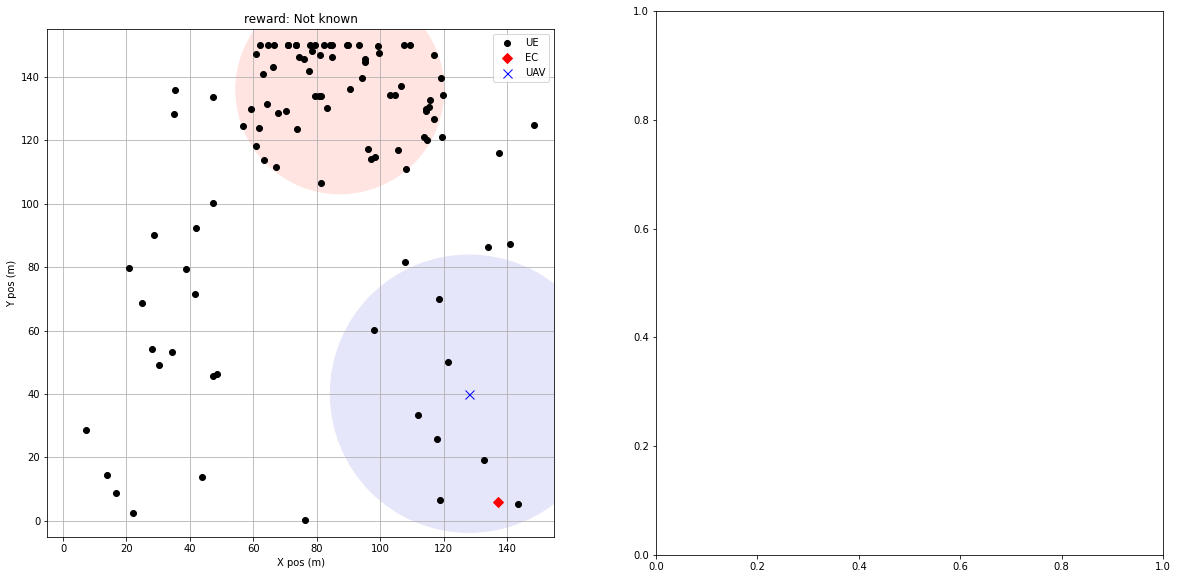

In [90]:
env.render()
print("Number of UEs covered: ", env.get_count_of_UEs_covered())

In [91]:
# env.reset()
# env.render()

In [92]:
# learning_steps = 10000
# checker = tf.convert_to_tensor(env.current_state)
# v = tf.Variable(checker)
# # x = tf.Variable(env.current_state[0])
# # y = tf.Variable(env.current_state[1])
# for i in range(learning_steps):
#   with tf.GradientTape() as tape:

#     # Continuous Reward
#     ratio_for_calculating_k = 0.7
#     k = int(ratio_for_calculating_k * env.UE_count)
#     UE_ground_positions = tf.convert_to_tensor(env.UE_positions[: ,:2])
#     # horizontal_dist_UE_UAV = tf.norm(UE_ground_positions - [x, y], axis = 1)
#     horizontal_dist_UE_UAV = tf.norm(UE_ground_positions - v, axis = 1)
#     print("x: ", v[0], ", y: ", v[1])
#     # print("type(hor): ", type(horizontal_dist_UE_UAV))
#     # print("horizontal_dist_UE_UAV array: ", horizontal_dist_UE_UAV)
#     horizontal_dist_UE_UAV = tf.sort(horizontal_dist_UE_UAV)
#     # print("closest UE positions: ", horizontal_dist_UE_UAV[:k])
#     loss = tf.math.reduce_sum(horizontal_dist_UE_UAV[:k])

#     # # Discrete Reward
#     # C_max_t = (env.Z_max / np.tan(env.phi_n))
#     # UE_ground_positions = tf.convert_to_tensor(env.UE_positions[: ,:2])
#     # horizontal_dist_UE_UAV = tf.norm(UE_ground_positions - [x, y], axis = 1)
#     # rho_array = tf.cast((horizontal_dist_UE_UAV <= (tf.convert_to_tensor(C_max_t))), tf.float32)  # binary association vector
#     # M_t = tf.reduce_sum(rho_array)  # no. of UEs served by the agent
#     # print("M_t: ", M_t)
#     # loss = (env.UE_count - M_t) * 25
#     print("loss: ", loss)


#     # Gradient Descent
#     grads = tape.gradient(loss, v)
#     print("gradients: ", grads)
#     print("--------------------------------------------------------")
#     optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=0.1)
#     # optimizer.apply_gradients(zip(grads, [x, y]))
#     print("type(v): ", v)
#     optimizer.apply_gradients(zip(grads, v))

In [93]:
# with tf.GradientTape() as t1:
#     a = tf.Variable(1.)
#     b = 2*a
#     gr = t1.gradient(b, a)
#     print(gr)

In [112]:
state_low = env.state_space.low
state_high = env.state_space.high
action_low = env.action_space.low 
action_high = env.action_space.high


class ANN(tf.keras.Model):
  def __init__(self, no_action):
    super(ANN, self).__init__()    
    self.f1 = tf.keras.layers.Dense(512, activation='relu')
    self.f2 = tf.keras.layers.Dense(512, activation='relu')
    self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

  def call(self, state):
    x = self.f1(state)
    x = self.f2(x)
    x = self.mu(x)  
    return x
  


no_action= len(env.action_space.high)
network = ANN(no_action)
network_optimizer = tf.keras.optimizers.Adam(0.000001)  # 0.001

total_learning_episodes = 10000
current_episode = 0
while current_episode < total_learning_episodes:
    print("iteration ", current_episode)
    done = False
    env.reset()
    current_episode_total_reward = 0
    current_episode_num_steps = 0
    current_episode_final_reward = 0
    while not done:
      with tf.GradientTape() as tape:
        tf_state = tf.convert_to_tensor([env.current_state], dtype=tf.float32)
        tf_action = network(tf_state)
        #TESTING 
        # #Declaring reward as sum of tf_action (just to check the erroreneous part)
        # reward = tf.math.reduce_sum(tf_action)
        # #TESTING CODE ENDS
        # print("action: ", tf_action)
        next_state, reward, done, _ = env.step(tf_action)
        # loss = reward
        current_episode_total_reward += reward.numpy()
        current_episode_num_steps += 1
        current_episode_final_reward = reward.numpy()
        # Gradient Descent
        grads = tape.gradient(reward, network.trainable_variables)
        print("gradient: ", tf.math.reduce_sum(grads[2]))
        grads = [tf.clip_by_value(grad, -1., 1.) for grad in grads]
        print("clipped gradient: ", tf.math.reduce_sum(grads[2]))
        network_optimizer.apply_gradients(zip(grads, network.trainable_variables))
        done = True

    current_episode += 1
    print("Average reward in episode ", current_episode, ": ", current_episode_total_reward / current_episode_num_steps)
    print("Final reward in episode ", current_episode, ": ", current_episode_final_reward)
    print("------------------------------------------------------------------------------")
    print()

Streaming output truncated to the last 5000 lines.

iteration  3511
gradient:  tf.Tensor(-1027.6316, shape=(), dtype=float32)
clipped gradient:  tf.Tensor(-1027.6316, shape=(), dtype=float32)
Average reward in episode  3512 :  -7951.30126953125
Final reward in episode  3512 :  -7951.3013
------------------------------------------------------------------------------

iteration  3512
gradient:  tf.Tensor(-19.338146, shape=(), dtype=float32)
clipped gradient:  tf.Tensor(-19.338146, shape=(), dtype=float32)
Average reward in episode  3513 :  -8417.8779296875
Final reward in episode  3513 :  -8417.878
------------------------------------------------------------------------------

iteration  3513
gradient:  tf.Tensor(-3.251111, shape=(), dtype=float32)
clipped gradient:  tf.Tensor(-3.251111, shape=(), dtype=float32)
Average reward in episode  3514 :  -5228.39892578125
Final reward in episode  3514 :  -5228.399
------------------------------------------------------------------------------

it

KeyboardInterrupt: ignored

action:  [ 1. -1.]


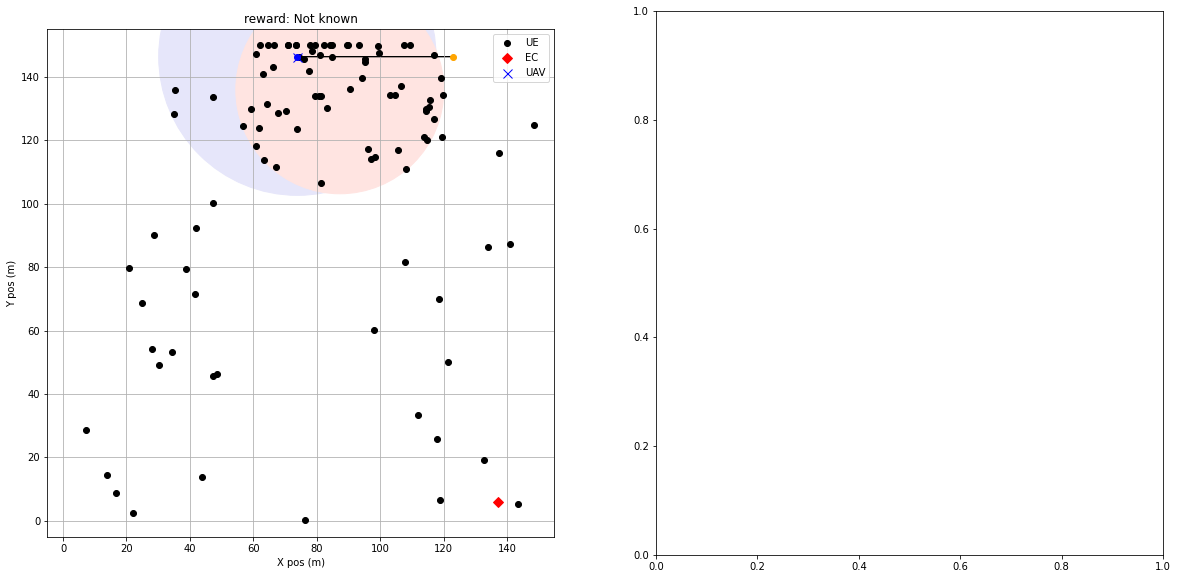

In [119]:
env.reset()
tf_state = tf.convert_to_tensor([env.current_state], dtype=tf.float32)
tf_action = network(tf_state)
position_action_list = []
action = tf_action.numpy().flatten()
print("action: ", action)
position_action_list.append((tf_state.numpy().flatten(), action))
env.render(learnt_policy_visualization = True, position_action_list = position_action_list)

In [ ]:
print(tf.config.list_physical_devices('GPU'))

state_low = env.state_space.low
state_high = env.state_space.high
action_low = env.action_space.low 
action_high = env.action_space.high
# print(state_low)
# print(state_high)
# print(action_low)
# print(action_high)


class RBuffer():
  def __init__(self, maxsize, statedim, naction):
    print("maxsize: ", maxsize)
    self.cnt = 0
    self.maxsize = maxsize
    self.state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
    self.action_memory = np.zeros((maxsize, naction), dtype=np.float32)
    self.reward_memory = np.zeros((maxsize,), dtype=np.float32)
    self.next_state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
    self.done_memory = np.zeros((maxsize,), dtype= np.bool)

  def storexp(self, state, next_state, action, done, reward):
    index = self.cnt % self.maxsize
    self.state_memory[index] = state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.next_state_memory[index] = next_state
    self.done_memory[index] = 1- int(done)
    self.cnt += 1

  def sample(self, batch_size):
    max_mem = min(self.cnt, self.maxsize)
    batch = np.random.choice(max_mem, batch_size, replace= False)  
    states = self.state_memory[batch]
    next_states = self.next_state_memory[batch]
    rewards = self.reward_memory[batch]
    actions = self.action_memory[batch]
    dones = self.done_memory[batch]
    return states, next_states, rewards, actions, dones


class Critic(tf.keras.Model):
  def __init__(self):
    super(Critic, self).__init__()
    self.f1 = tf.keras.layers.Dense(512, activation='relu')
    self.f2 = tf.keras.layers.Dense(512, activation='relu')
    self.v =  tf.keras.layers.Dense(1, activation=None)

  def call(self, inputstate, action):
    x = self.f1(tf.concat([inputstate, action], axis=1))
    x = self.f2(x)
    x = self.v(x)
    return x


class Actor(tf.keras.Model):
  def __init__(self, no_action):
    super(Actor, self).__init__()    
    self.f1 = tf.keras.layers.Dense(512, activation='relu')
    self.f2 = tf.keras.layers.Dense(512, activation='relu')
    self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

  def call(self, state):
    x = self.f1(state)
    x = self.f2(x)
    x = self.mu(x)  
    return x

 

class Agent():
  def __init__(self, n_action= len(env.action_space.high)):
    self.actor_main = Actor(n_action)
    self.actor_target = Actor(n_action)
    self.critic_main = Critic()
    self.critic_main2 = Critic()
    self.critic_target = Critic()
    self.critic_target2 = Critic()
    self.batch_size = 64
    self.n_actions = len(env.action_space.high)
    self.a_opt = tf.keras.optimizers.Adam(0.0001)  # 0.001
    # self.actor_target = tf.keras.optimizers.Adam(0.0001)  # 0.001
    self.c_opt1 = tf.keras.optimizers.Adam(0.0002)  # 0.002
    self.c_opt2 = tf.keras.optimizers.Adam(0.0002)  # 0.002
    # self.critic_target = tf.keras.optimizers.Adam(0.0002)  # 0.002
    self.memory = RBuffer(1_00_000, env.state_space.shape, len(env.action_space.high))
    self.trainstep = 0
    #self.replace = 5
    self.gamma = 0.99
    self.min_action = env.action_space.low
    self.max_action = env.action_space.high
    self.actor_update_steps = 2
    self.warmup = 200
    self.actor_target.compile(optimizer=self.a_opt)
    self.critic_target.compile(optimizer=self.c_opt1)
    self.critic_target2.compile(optimizer=self.c_opt2)
    self.tau = 0.005
    

  def act(self, state, evaluate=False):
      if self.trainstep > self.warmup:
            evaluate = True
      state = tf.convert_to_tensor([state], dtype=tf.float32)
      actions = self.actor_main(state)
      if not evaluate:
          actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

      actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
      # print("actions: ", actions)
      return actions


  def savexp(self,state, next_state, action, done, reward):
        self.memory.storexp(state, next_state, action, done, reward)

  def update_target(self, tau=None):
  
    if tau is None:
        tau = self.tau

    weights1 = []
    targets1 = self.actor_target.weights
    for i, weight in enumerate(self.actor_main.weights):
        weights1.append(weight * tau + targets1[i]*(1-tau))
    self.actor_target.set_weights(weights1)

    weights2 = []
    targets2 = self.critic_target.weights
    for i, weight in enumerate(self.critic_main.weights):
        weights2.append(weight * tau + targets2[i]*(1-tau))
    self.critic_target.set_weights(weights2)


    weights3 = []
    targets3 = self.critic_target2.weights
    for i, weight in enumerate(self.critic_main2.weights):
        weights3.append(weight * tau + targets3[i]*(1-tau))
    self.critic_target2.set_weights(weights3)

  
  def train(self, s=0, gradient_list=None, done=False):
      if self.memory.cnt < self.batch_size:
        return 


      states, next_states, rewards, actions, dones = self.memory.sample(self.batch_size)
  
      states = tf.convert_to_tensor(states, dtype= tf.float32)
      next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
      rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
      actions = tf.convert_to_tensor(actions, dtype= tf.float32)
      #dones = tf.convert_to_tensor(dones, dtype= tf.bool)

      with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
          target_actions = self.actor_target(next_states)
          target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.1), -0.2, 0.2)
          target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))
          
          
          target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
          target_next_state_values2 = tf.squeeze(self.critic_target2(next_states, target_actions), 1)
          
          critic_value = tf.squeeze(self.critic_main(states, actions), 1)
          critic_value2 = tf.squeeze(self.critic_main2(states, actions), 1)
          
          next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)
          
          target_values = rewards + (self.gamma * next_state_target_value * dones)

          critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
          critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)
          


      
      grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
      # print("grads: ", grads1[0])
      # print("gradient list length: ", type(grads1[0]))
      grads1 = [tf.clip_by_value(grad, -1., 1.) for grad in grads1]
      # print("length of gradients: ", len(grads1[0]))
      if(done):
          print("sum of gradients: ", tf.math.reduce_sum(tf.math.abs(grads1[0])))
      # print("max gradient value: ", tf.math.reduce_max(grads1[0]))
      # print("min gradient value: ", tf.math.reduce_min(grads1[0]))
      if((s%100) == 0):
          gradient_list.append(grads1)
      

      grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)
      # print("gradient list length: ", len(grads2))
      grads2 = [tf.clip_by_value(grad, -1., 1.) for grad in grads2]
      # print("clipped max gradient: ", tf.math.reduce_max(grads1[0]))
      # print("clipped min gradient: ", tf.math.reduce_min(grads1[0]))

      self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
      self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))
      
      
      self.trainstep +=1
      
      if self.trainstep % self.actor_update_steps == 0:
                
          with tf.GradientTape() as tape3:
            
              new_policy_actions = self.actor_main(states)
              actor_loss = -self.critic_main(states, new_policy_actions)
              actor_loss = tf.math.reduce_mean(actor_loss)
          
          grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
          # print("gradient list length: ", len(grads3))
          grads3 = [tf.clip_by_value(grad, -1., 1.) for grad in grads3]
          self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

      #if self.trainstep % self.replace == 0:
      self.update_target()
           
      

critic_1_gradient_list = []
reward_array = []


with tf.device('GPU:0'):
    tf.random.set_seed(336699)
    agent = Agent()
    episods = 20000
    ep_reward = []
    total_avgr = []
    target = False

    for s in range(episods):
      if target == True:
        break
      total_reward = 0 
      state = env.reset()
      done = False

      while not done:
        #env.render()
        action = agent.act(state)
        # print("action: ", action)
        next_state, reward, done, _ = env.step(action)
        cnt = 10 if (reward>0) else 1
        for i in range(cnt):
            agent.savexp(state, next_state, action, done, reward)
        agent.train(s, critic_1_gradient_list, done)
        state = next_state
        total_reward += reward
        if done:
            reward_array.append(total_reward)
            ep_reward.append(total_reward)
            avg_reward = np.mean(ep_reward[-100:])
            total_avgr.append(avg_reward)
            print("total reward after {} steps is {} and avg reward is {}".format(s, total_reward, avg_reward))
            # if int(avg_reward) == 200:
            #   target = True





[]
maxsize:  100000


<ipython-input-70-d7ab8b3d34d0>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done_memory = np.zeros((maxsize,), dtype= np.bool)


sum of gradients:  tf.Tensor(1089.3062, shape=(), dtype=float32)
total reward after 0 steps is 56067.1893163841 and avg reward is 56067.1893163841
sum of gradients:  tf.Tensor(1132.0, shape=(), dtype=float32)
total reward after 1 steps is 86872.11084221276 and avg reward is 71469.65007929843
sum of gradients:  tf.Tensor(1132.0, shape=(), dtype=float32)
total reward after 2 steps is 64826.00542951083 and avg reward is 69255.10186270256
sum of gradients:  tf.Tensor(1340.0, shape=(), dtype=float32)
total reward after 3 steps is 190557.19651447097 and avg reward is 99580.62552564466
sum of gradients:  tf.Tensor(1340.0, shape=(), dtype=float32)
total reward after 4 steps is 112420.16337255116 and avg reward is 102148.53309502595
sum of gradients:  tf.Tensor(1372.0, shape=(), dtype=float32)
total reward after 5 steps is 132408.58939681342 and avg reward is 107191.87581199054
sum of gradients:  tf.Tensor(1372.0, shape=(), dtype=float32)
total reward after 6 steps is 154791.61596421184 and avg

KeyboardInterrupt: ignored

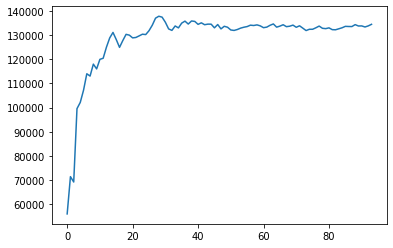

In [ ]:
plt.plot(np.arange(len(total_avgr)), total_avgr)
plt.show()

action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]
action:  [-1.  1.]


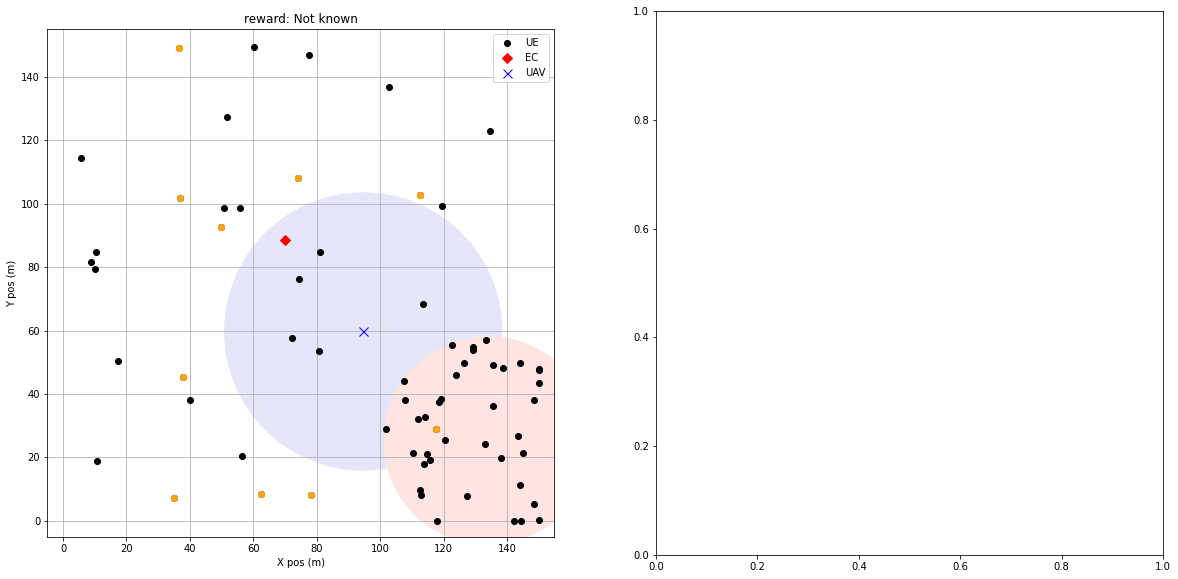

In [ ]:
def plot_learnt_policy():

    n_points = 10
    position_action_list = []
    for i in range(n_points):
        x = np.random.uniform(0, env.boundary_x)
        y = np.random.uniform(0, env.boundary_y)
        # x = env.boundary_x
        # y = env.boundary_y
        # print("current_state: ", x, y)
        action = np.array(agent.act([x, y])).flatten()
        print("action: ", action)
        position_action_list.append(([x, y], action))
    env.render(learnt_policy_visualization = True, position_action_list = position_action_list)

plot_learnt_policy()

In [ ]:

bins = [i for i in range(-100, 100, 40)]
plt.hist(critic_1_gradient_list[4][2], bins=bins)
plt.show()

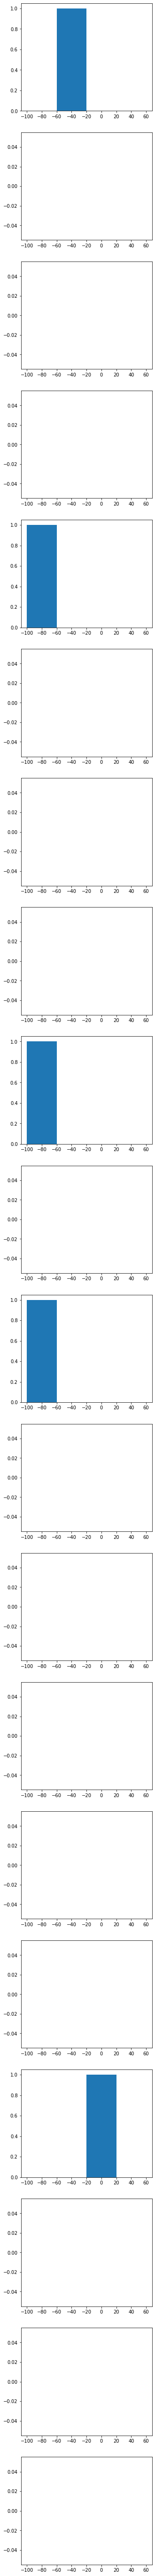

In [ ]:
bins = [i for i in range(-100, 100, 40)]
fig, ax = plt.subplots(20, figsize =(5, 100))
for i in range(20):
  ax[i].hist(critic_1_gradient_list[i*20][5], bins=bins)
plt.show()

In [ ]:
def run_random_episode(agent):
    '''
    Helper function to visualize training
    This function runs an entire episode using the policy output by the actor network, \
    and plots the UAV position graph at 10 equally spaced timesteps. 
    '''
    obs = env.reset()
    num_figs = 10
    gap_ = 1
    done = False
    i = 0
    fig, axes = plt.subplots(num_figs, 2, figsize=(10, 100))
    while not done:
        action = agent.act(np.array(obs))
        obs, reward, done, _ = env.step(action)
        if((i % gap_ == 0) and (i / gap_ < num_figs)):
            env.render(fig = fig, ax = axes, i = int(i // gap_), reward = reward)
        i += 1
    return

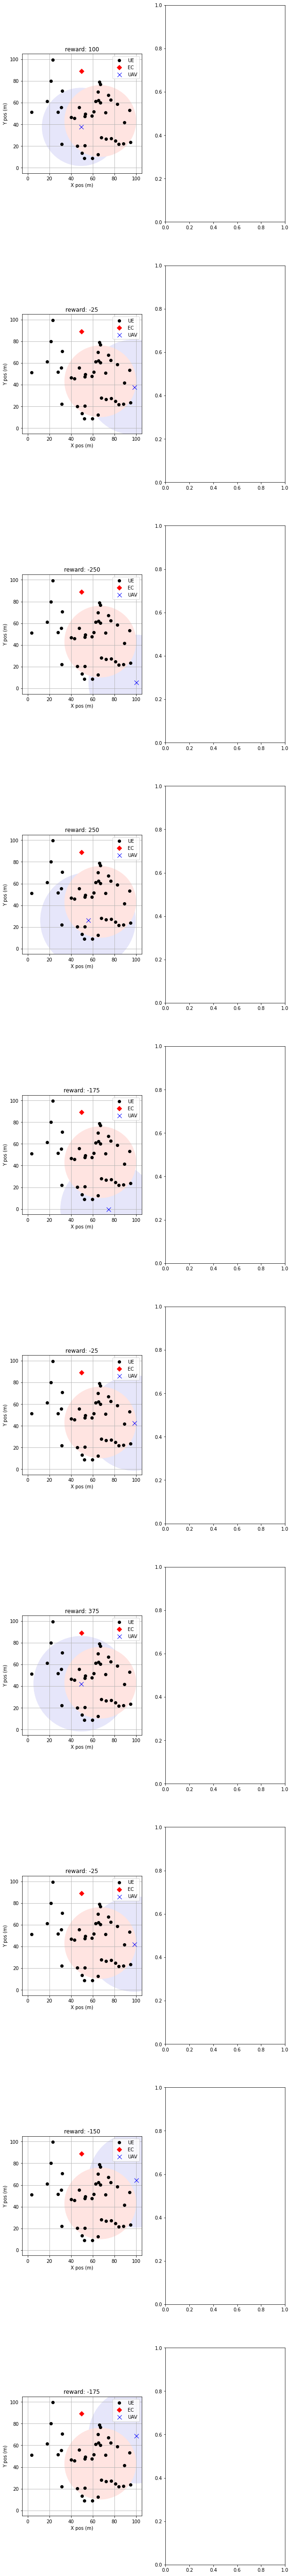

In [ ]:
run_random_episode(agent)

In [ ]:
ep = [i  for i in range(len(avg_rewards_list))]
plt.plot( range(len(avg_rewards_list)),avg_rewards_list,'b')
plt.title("Avg Test Aeward Vs Test Episods")
plt.xlabel("Test Episods")
plt.ylabel("Average Test Reward")
plt.grid(True)
plt.show()